In [27]:
import torch
import torch.nn as nn

The link to the paper: `https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf`

The salient features:

1. Uses 1x1 cnn for dimensionality reduction

Inception net

![](https://i.ytimg.com/vi/KfV8CJh7hE0/maxresdefault.jpg)

So it has multiple conv block and inception block lets build them one by one
# Conv block & Inception block

In [28]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.relu(self.batchnorm(self.cnn(x)))

In [29]:
class inception_block(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, out1x1pool):
        super(inception_block, self).__init__()
        
        self.branch1 = conv_block(in_channels, out1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            
            conv_block(in_channels, red3x3, kernel_size=1),
            conv_block(red3x3, out3x3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red5x5, kernel_size=1),
            conv_block(red5x5, out5x5, kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out1x1pool, kernel_size=1)
        )
        
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

![](https://media.geeksforgeeks.org/wp-content/uploads/20200429201421/Inception-layer-by-layer.PNG)

In [30]:
class GoogLeNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=104):
        super(GoogLeNet,self).__init__()
        self.conv1 = conv_block(in_channels, 64,kernel_size=(7,7), stride=(2,2),padding=(3,3))
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception4a = inception_block(480, 192, 86, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        
        self.fc1 = nn.Linear(1024,num_classes)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        
        x = self.inception4a(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        
        return x
        
        
        
        
    

In [31]:
model = GoogLeNet()

In [32]:
x = torch.randn(10, 3, 224,224)
y = model(x)
y.shape

torch.Size([10, 104])

torch.Size([224, 224, 3])

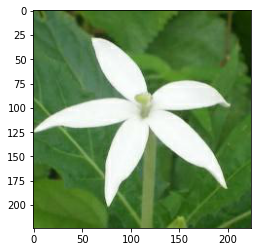

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('../input/104-flowers-garden-of-eden/jpeg-224x224/train/balloon flower/10108.jpeg')
img = np.array(img)
img = torch.tensor(img)
plt.imshow(img)
img.shape


In [34]:
x = img.permute(2,0,1)
x = x.unsqueeze(0)
x = x.float()
print(x.shape)
y = model(x)
"output shape: " , y.shape

torch.Size([1, 3, 224, 224])


('output shape: ', torch.Size([1, 104]))

lets use flower dataset

In [35]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [36]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor(),
                                      normalize])

In [37]:
test_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     normalize])

In [38]:
from torchvision.datasets import ImageFolder

torch.Size([3, 224, 224]) 0


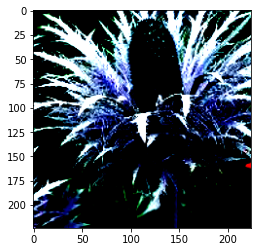

In [39]:
train_data = ImageFolder(root="../input/104-flowers-garden-of-eden/jpeg-224x224/train", transform=train_transform)

z,y = train_data[0]
print(z.shape,y)

plt.imshow(z.permute(1,2,0))

In [40]:
train_dataloader = DataLoader(dataset=train_data, shuffle=True, batch_size=64)

torch.Size([3, 224, 224]) 0


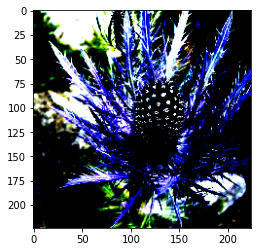

In [41]:
test_data = ImageFolder(root="../input/104-flowers-garden-of-eden/jpeg-224x224/val", transform=test_transform)

z,y = test_data[0]
print(z.shape, y)

plt.imshow(z.permute(1,2,0))

In [42]:
test_dataloader = DataLoader(dataset=test_data,shuffle=True, batch_size=64)

In [43]:
num_epoch = 5
batch_size= 64
learning_rate = 0.001

I dont want to wastetime by training from scratch so lets use pretrained model.

In [44]:
from torchvision.models import googlenet

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
model = googlenet(pretrained=True)

In [47]:
model.fc = nn.Linear(in_features=1024, out_features=104)

In [48]:
model = model.to(device=device)

In [49]:
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
for epoch in range(num_epoch):
    for data, target in train_dataloader:
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        optimizer.zero_grad()
        loss = loss_criterion(score,target)
        
        loss.backward()
        
        optimizer.step()
    print(f"for epoch {epoch}, loss: {loss}")
        
        

for epoch 0, loss: 1.4919872283935547
for epoch 1, loss: 1.8422871828079224
for epoch 2, loss: 0.6083251237869263
for epoch 3, loss: 0.8853777647018433
for epoch 4, loss: 1.0711098909378052


In [51]:
def check_accuracy(model, loader):
    model.eval()
    
    correct_sample = 0
    total_sample = 0
    
    for x, y  in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        
        score = model(x)
        
        _, predictions = score.max(1)
        
        correct_sample = (y==predictions).sum()
        total_sample = predictions.shape[0]
    
    model.train()
    print(f"Total accuracy : {float(correct_sample/total_sample)*100}")
    

In [52]:
check_accuracy(model, train_dataloader)

Total accuracy : 76.47058963775635


In [ ]:
check_accuracy(model, test_dataloader)